In [3]:
# do it for one person first and then check it for multiple persons 

In [4]:
import cv2
import numpy as np
import random
import os
from matplotlib import pyplot as plt

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

2023-10-09 08:02:48.642488: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-09 08:02:49.148578: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-09 08:02:49.150640: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 08:02:50.851146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [7]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [Errno 17] File exists: 'data/positive'

In [ ]:
!tar -xf lfw.tgz

In [8]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)
        

In [9]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [10]:
def preprocess(file_path):
    # reads the image
    byte_img = tf.io.read_file(file_path)
    # loads the image
    img = tf.io.decode_jpeg(byte_img)
    # resizing/ preprocessing the image
    img = tf.image.resize(img, (100, 100))
    img  = img/255.0
    return img

In [11]:
tf.ones_like(1)

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [12]:
# the zip method create tuples containing anchor, positive or negative , 1 or 0 based on the previous value
positives = tf.data.Dataset.zip((anchor, positive , tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

In [13]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)                           

In [14]:
data = positives.concatenate(negatives)
samples = data.as_numpy_iterator()
example = samples.next()
# tuple of three values
example

(b'data/anchor/a756940e-5b00-11ee-b510-41c5767b88c9.jpg',
 b'data/positive/b044f017-5b00-11ee-b510-41c5767b88c9.jpg',
 1.0)

1.0

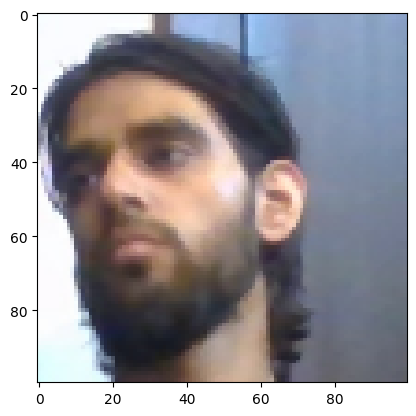

In [15]:
res = preprocess_twin(*example)
plt.imshow(res[1])
res[2]

In [16]:
data = data.map(preprocess_twin)
# caches data into the memory after it is preprocessed
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [17]:
# takes 70% of the data
train_data = data.take(round(len(data)*.7))
# creates batches of 16 i.e 1 batch of data contains 16 elements
train_data = train_data.batch(16)
# it overlaps data loading and model training techniques makes them work simultaniously
train_data = train_data.prefetch(8)

In [18]:
train_samples = train_data.as_numpy_iterator()
len(train_samples.next()[0])

16

In [19]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [20]:
def make_embedding():
    inp =  Input(shape= (100, 100,3), name='input_image')

    # first block
    c1 = Conv2D(64, (10, 10), activation = 'relu')(inp)
    m1 =  MaxPooling2D(64, (2, 2), padding='same')(c1)

    # second block
    c2 = Conv2D(128, (7, 7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)

    # third block
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)
    
    # final embedding block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp], outputs=[d1] , name='embedding')

In [21]:
#applying the embedding network
embedding = make_embedding()  #embedding becomes a model object
embedding.summary()

2023-10-09 08:03:40.400649: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.
2023-10-09 08:03:40.477053: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.
2023-10-09 08:03:40.534807: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.


Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [22]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [23]:
input_image = Input(name = 'input_img', shape = (100, 100, 3))
validation_image = Input(name= 'validation_img', shape=(100, 100, 3))


In [24]:

inp_embedding = embedding(input_image) #model object if fed with input images
val_embedding = embedding(validation_image)
siamese_layer = L1Dist() #siamese layer is made into an layer object
siamese_layer(inp_embedding, val_embedding) # the custom layer is fed with inp_image models and op_image model

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist')>

In [25]:
emb = embedding(input_image) #this is a model object

In [26]:
def make_siamese_model():
    # anchor image input in the network
    input_image = Input(name = 'input_img', shape = (100, 100, 3))

    # validation image in the network
    validation_image = Input(name= 'validation_img', shape=(100, 100, 3))

    # combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs = [input_image, validation_image], outputs = classifier, name='SiameseNetwork')

In [27]:
siamese_model = make_siamese_model()

In [28]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [29]:
opt = tf.keras.optimizers.Adam(1e-4)

In [30]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model=siamese_model)

In [31]:
checkpoint_dir

'./training_checkpoints'

In [39]:
test_batch = train_data.as_numpy_iterator()
batch1 = test_batch.next()
batch1[2]

array([1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

In [40]:
@tf.function
def train_step(batch):
    
    # record all of our operations
    with tf.GradientTape as tape:
        # get anchor and positive/negative images
        x = batch[: 2]
        # get label
        y = batch[2]

        # forward pass
        yaht = siamese_model(x, training = True)
        # calculate loss
        loss = binary_cross_loss(y, yaht)

    print(loss)

    # calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    # calculate updates weights and apply siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss
